# Passes to Parameters

So it turns out that pyephem does all the stuff we need to do very nicely, and matches the predictions from both gpredict and heavens-above, so let's just use that.  With that out of the way, we can move on to estimating the parameters needed to actually track these satellites.  Specifically, we can make estimates of the required altitude and azimuth slew rates, as well as getting an idea of the distances involved.  Without more information about the sizes of each satellite, it's hard to say what sorts of things we could see, but that's a separate issue for now.

So, first up, alt/az slew rates for a bunch of passes.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Set up our observer, which is wonderfully painless in pyephem.

In [2]:
import ephem

qth = ephem.Observer()
qth.lat = np.deg2rad(37.7282)
qth.lon = np.deg2rad(-122.4070)
qth.elevation = 25

Now, let's just load up the TLE data that gpredict has stashed for us:

In [3]:
import glob
import ConfigParser # INI Files, yay!

def sat_to_body(path):
    cp = ConfigParser.RawConfigParser()
    cp.read(path)
    secname = 'Satellite'
    name = cp.get(secname, 'name')
    tle1 = cp.get(secname, 'TLE1')
    tle2 = cp.get(secname, 'TLE2')
    return ephem.readtle(name, tle1, tle2)

satellites = {} # SSN => PyEphem object

for p in glob.glob("/home/jbm/.config/Gpredict/satdata/*.sat"):
    ssn = int(p[p.rindex('/')+1:-4])
    satellites[ssn] = sat_to_body(p)
    
len(satellites)

2220

## Plotting our plotting
First, let's get our polar plotting in order, to make things easier to reason about.  Then we'll see what's in the sky right now, because why not really.

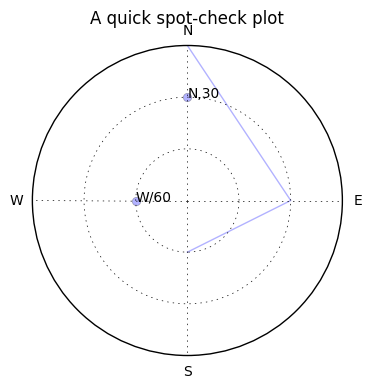

In [4]:
def az2polar(az):
    return np.pi/2 - az

def alt2polar(alt):
    return np.pi/2 - alt

def alt2polardeg(alt):
    return np.rad2deg(alt2polar(alt))

ax = subplot(111, projection='polar')

azs = np.array([0,np.pi/2, np.pi]) # N, E, S
alts = np.array([0, np.pi/6, np.pi/3]) # horizon, 30, 60

az_p = az2polar(azs)
alt_p = alt2polardeg(alts)

ax.plot(az_p, alt_p, color="blue", alpha=0.3);

for az,alt,lab in [ (0, np.pi/6, "N,30"), (3*np.pi/2, np.pi/3, "W/60") ]:
    plot(az2polar(az), alt2polardeg(alt), 'o', color='blue', alpha=0.3)
    ax.text(az2polar(az), alt2polardeg(alt), lab)


yticks([30,60], [])
xticks(np.pi/2*np.arange(4), "ENWS")
title('A quick spot-check plot');

## What's in the sky right now?

With that out of the way, what's in the sky right now?

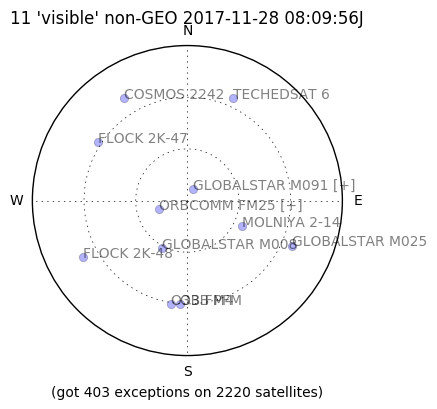

In [5]:
visibles = []

dt0 = datetime.datetime.utcnow()

n_exceptions = 0

max_elevation = 10000000 # maximum satellite elevation: skip GEO birds.
min_alt = 20 # minimum altitude to consider, in degrees

qth = ephem.Observer()
qth.lat = np.deg2rad(37.7282)
qth.lon = np.deg2rad(-122.4070)
qth.elevation = 25
qth.date = dt0

for ssn, o in satellites.iteritems():
    try:
        o.compute(qth)
        
        if o.elevation > max_elevation:
            continue

        if o.alt > np.deg2rad(min_alt):
            visibles.append((ssn, o.alt, o.az, o.range))
                    
    except Exception, e:
        n_exceptions += 1
        pass
    
ax = subplot(111, projection='polar')
p = [ (0, 0,0), (0, np.pi/6, np.pi/2), (0,np.pi/3, np.pi), (0,np.pi, 1.5*np.pi)]

yticks([30,60], [])
xticks(np.pi/2*np.arange(4), "ENWS")
ylim(0,90)

for ssn,alt,az,rng in visibles:
    azp = az2polar(az)
    altp = alt2polardeg(alt)
    ax.plot(azp, altp, 'o', color='blue', alpha=0.3)
    ax.text(azp, altp, satellites[ssn].name, alpha=0.5)
    
tstr = "%d 'visible' non-GEO %s" % (len(visibles), dt0.strftime("%Y-%m-%d %H:%M:%SJ"))
ax.set_xlabel("(got %d exceptions on %d satellites)" % (n_exceptions, len(satellites)))
    
ax.set_title(tstr);

## Collecting a week's worth of visible passes

Let's run all the satellites through a week's worth of passes, and see what that looks like.  It turns out that we can see geostationary satellites all the time, which makes them uninteresting, so we skip anything over 10,000km up.

In [6]:
passes = []

dt0 = datetime.datetime.utcnow()

TIME_RESOLUTION = 30

dates = [ dt0 + datetime.timedelta(seconds=TIME_RESOLUTION*i) for i in range(7*24*60) ] # a week of 30s

n_exceptions = 0
n_ssns = 0

for ssn, o in satellites.iteritems():
    if n_ssns % 250 == 0:
        print "# %d satellites, %d passes, %d exceptions" % (n_ssns, len(passes), n_exceptions)
    n_ssns += 1
    try:
        qth.date = datetime.datetime.utcnow()
    
        o.compute(qth)
        
        # skip the GEO satellites right up front, don't enter the loop below for them.
        if o.elevation > max_elevation:
            continue
    
        curpass = []
        
        for dt in dates:
            qth.date = dt
            o.compute(qth)
            
            if o.alt > 0:
                curpass.append( (ssn, o.alt, o.az, o.range, dt) )
            elif curpass:
                if len(curpass) > 5: # tiny passes are either too low or too fast to be useful
                    passes.append(curpass)
                curpass = []
    
    except Exception, e:
        n_exceptions += 1
        pass
    
len(passes)

# 0 satellites, 0 passes, 0 exceptions
# 250 satellites, 2779 passes, 39 exceptions
# 500 satellites, 6468 passes, 64 exceptions
# 750 satellites, 9929 passes, 104 exceptions
# 1000 satellites, 12562 passes, 148 exceptions
# 1250 satellites, 14298 passes, 215 exceptions
# 1500 satellites, 16136 passes, 274 exceptions
# 1750 satellites, 18145 passes, 321 exceptions
# 2000 satellites, 20835 passes, 366 exceptions


22479

That's a fair number of passes.  As a sanity check, what does the ISS look like in these?

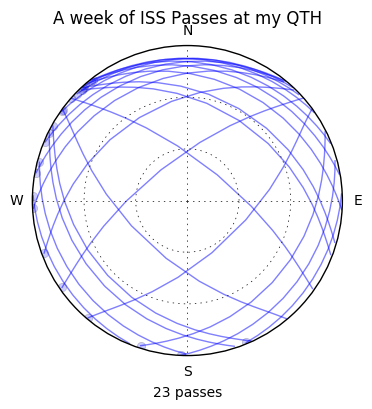

In [7]:
iss_passes = [ p for p in passes if p[0][0] == 25544 ]

ax = subplot(111, projection='polar')
for p in iss_passes:
    az_proj = az2polar(np.array([ e[2] for e in p ]))
    alt_proj = alt2polardeg(np.array([e[1] for e in p ]))
    
    ax.plot(az_proj, alt_proj, color="blue", alpha=0.5);
    ax.plot(az_proj[0], alt_proj[0], 'o', color='blue', alpha=0.2)
       
title("A week of ISS Passes at my QTH")
xlabel("%d passes" %  len(iss_passes))
yticks([30,60], [])
xticks(np.pi/2*np.arange(4), "ENWS");

Okay, on to data collection.  Many of the passes seem to be very low on inspection.  Let's instead focus on the passes which might possibly be of interest, say those with a max altitude at least 45° above the horizon.

In [8]:
high_passes = [ p for p in passes if np.max([e[1] for e in p]) > np.deg2rad(45) ]
len(high_passes)

4942

That's more reasonable-sounding.  Let's do one more quick spot check of the data:

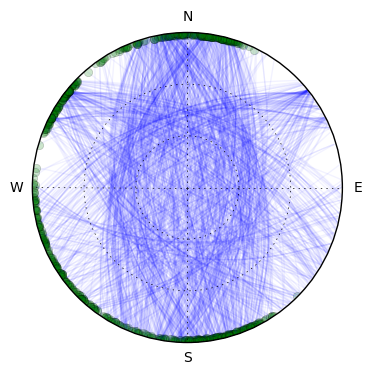

In [9]:
ax = subplot(111, projection='polar')
for p in np.random.choice(high_passes, size=1000):
    az_proj = az2polar(np.array([ e[2] for e in p ]))
    alt_proj = alt2polardeg(np.array([e[1] for e in p ]))
    
    ax.plot(az_proj, alt_proj, color="blue", alpha=0.05);
    ax.plot(az_proj[0], alt_proj[0], 'o', color='green', alpha=0.2)
   
yticks([30,60], [])
xticks(np.pi/2*np.arange(4), "ENWS");

## Reducing to alt/az slew rates

Now, to collect the deltas for the az/alt dimensions:

In [10]:
d_azes = []
d_alts = []

for p in high_passes:
    d_azes.extend(np.diff([e[2] for e in p]))
    d_alts.extend(np.diff([e[1] for e in p]))
        
d_azes = np.array(d_azes)
d_alts = np.array(d_alts)

d_azes = d_azes % (2*np.pi)
d_azes[d_azes > np.pi] -= 2*np.pi
len(d_azes), len(d_alts)

(182662, 182662)

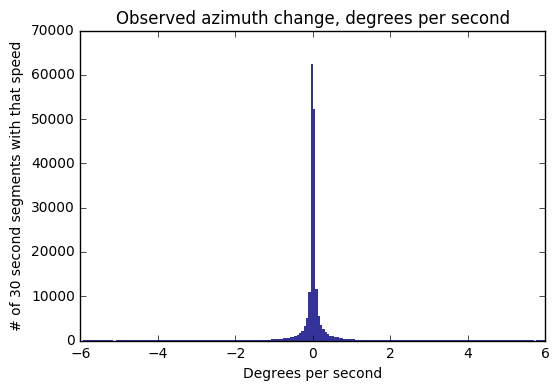

In [11]:
hist(np.rad2deg(d_azes)/TIME_RESOLUTION, bins=200, edgecolor='none', color="#333399");
title('Observed azimuth change, degrees per second')
xlabel('Degrees per second')
ylabel('# of 30 second segments with that speed')

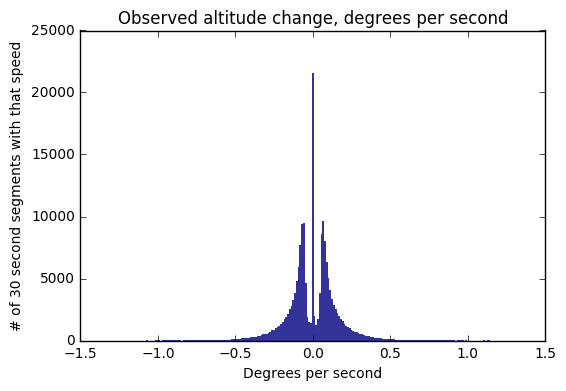

In [12]:
hist(np.rad2deg(d_alts)/TIME_RESOLUTION, bins=200, edgecolor='none', color="#333399");
title('Observed altitude change, degrees per second')
xlabel('Degrees per second')
ylabel('# of 30 second segments with that speed')

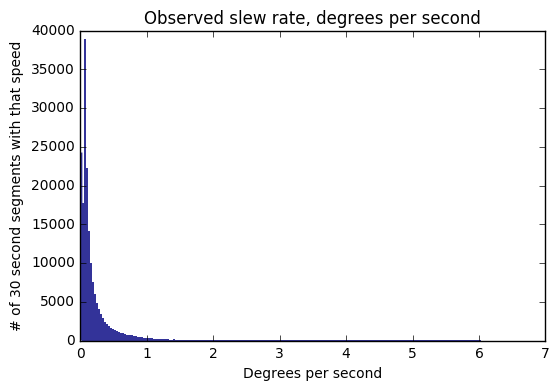

In [13]:
hist(np.rad2deg(np.sqrt(d_alts**2+d_azes**2))/TIME_RESOLUTION, bins=200, edgecolor='none', color="#333399");
title('Observed slew rate, degrees per second')
xlabel('Degrees per second')
ylabel('# of 30 second segments with that speed')

Okay, that all looks reasonable.  We need to be able to spin around at 10°/s to have plenty of headroom, and altitude slew rates of 5°/s should keep us within performance bounds.  This doesn't consider the requirements to slew between observations, which may be a useful thing to figure out when looking at the run planner software.  There's a lot of considerations for what targets to go after at what times, and there's also an interesting question of whether or not it's even worth attempting the lower passes (which has significant impact on how much slewing you need to do in both axes).

## Measuring optical limits

Now, let's look at the range to objects during passes.  1 arcsecond is about 50cm at 100km, which is far, far better than we're likely to capture.

First, we consider all visible satelites at all times:

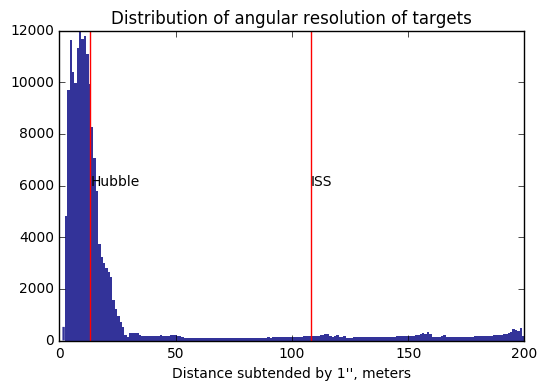

In [14]:
d_ranges = []

for p in high_passes:
    d_ranges.extend([e[3]/1000.0 for e in p])

d_ranges = np.array(d_ranges)
hist(d_ranges*0.50/100, bins=200, edgecolor='none', color="#333399");

for l,nom in [ (13.25, "Hubble"), (108, "ISS")]:
    axvline(l, color="red")
    text(l, 6000, nom)
    
xlim(0,4*0.5/100*max_elevation/1000)
xlabel("Distance subtended by 1'', meters")
title("Distribution of angular resolution of targets");

That's a lot of long-way-away!  What about only positions above 60°?

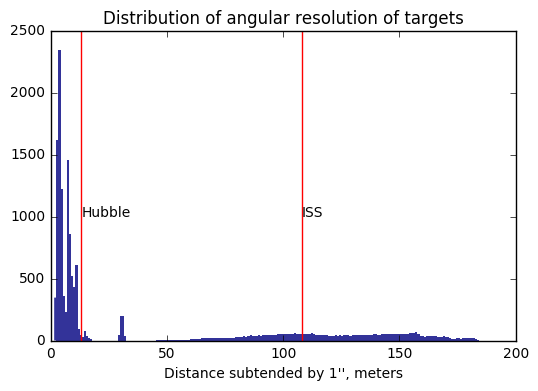

In [15]:
d_ranges = []

for p in high_passes:
    d_ranges.extend([e[3]/1000.0 for e in p if e[1] > np.pi/3])

d_ranges = np.array(d_ranges)
hist(d_ranges*0.50/100, bins=200, edgecolor='none', color="#333399");

for l,nom in [ (13.25, "Hubble"), (108, "ISS")]:
    axvline(l, color="red")
    text(l, 1000, nom)
    
xlim(0,4*0.5/100*max_elevation/1000)

xlabel("Distance subtended by 1'', meters")
title("Distribution of angular resolution of targets");

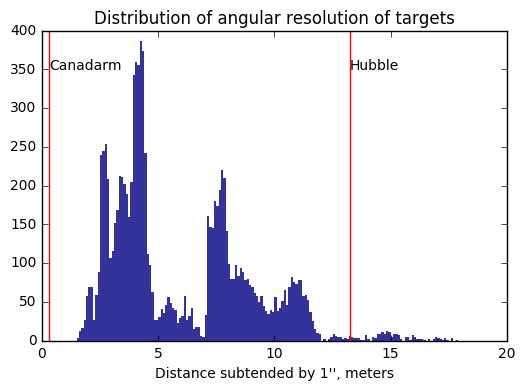

In [16]:
hist(d_ranges*0.50/100, bins=np.arange(0,20,0.1), edgecolor='none', color="#333399");

for l,nom in [ (13.25, "Hubble"), (0.3, 'Canadarm')]:
    axvline(l, color="red")
    text(l, 350, nom)
    
xlabel("Distance subtended by 1'', meters")
title("Distribution of angular resolution of targets");

That's not super encouraging.  I need to do more reading here, because this is making Legault-esque things look impossible.  I think a bit of work on estimating the apparent magnitude of satellites is worthwhile, and also doing more research on how the heck Legault processes his images to get the resolution he does.

### A quick thought experiment

I've seen a bunch of pictures that show details on the ISS pretty clearly, which means that it's definitely possible.  These are often movies, as well, which suggests that it's not just "lucky stacking" at work, but something deeper.  What's the theoretical requirement for that?  We know that we can just barely make out Canadarm in some photos, and that it's 38cm wide ([per Wikipedia's Canadarm page](https://en.wikipedia.org/wiki/Canadarm), so it must be true); let's use that as a starting point.

In [17]:
satellites[25544].name, satellites[25544].elevation/1000

('ISS (ZARYA)', 417.91965625)

In [18]:
canadarm_w = 0.38
canadarm_arcseconds = np.rad2deg(canadarm_w / satellites[25544].elevation)*3600
# pretty sure the small angle approximation is appropriate here... 

scope_d = 116.0/canadarm_arcseconds

print "Candarm subtends %0.3f arcseconds; this needs a %dmm scope (in theory)" % (canadarm_arcseconds, scope_d)

Candarm subtends 0.188 arcseconds; this needs a 618mm scope (in theory)


That's a 24" scope!  Furthermore, the best seeing at the best observatories is typically about 0.5as, so we're well beyond the theory at this point.  So, there must be particularly good tricks up these folks' sleeves.  Time to learn more.

Thierry Legault [describes his telescopes](http://www.astrophoto.fr/info.html) as all 14" or smaller, and image processing in [Iris](http://www.astrosurf.com/buil/us/iris/iris.htm) and [Prism](https://www.hyperion-astronomy.com/)